In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [6]:
'''
Creating a random graph

graph contains n destinations and m chargers

the random graph is completely connected
'''
deep_reload(src)

seed = 125396749
n = 15
m = 85
speeds = [105]
chargers = list(range(10))
scale = (1e6, 1e6)

graph = src.rng.random_completely_connected_graph(
    n, m, speeds = speeds, scale = scale, seed = seed, chargers = chargers,
)

In [134]:
'''
Adding station objects
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    capacity = 80 * 3.6e6,
    # max_charge_start_soc = 1,
    max_charge_start_soc = .5,
    risk_attitude = (.5, 1),
    cases = 30,
    # select_case = 6,
    # expectation = lambda x: x.mean(),
)

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            vehicle, chargers = node['n_dcfc']
        )

In [135]:
destinations = [n for n in graph.nodes if 'destination' in n]

In [139]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

t0 = time.time()

cost_s, values_s, paths_s = src.routing.shortest_paths(
    graph, ['destination_0'],
    destinations = destinations,
    objective = vehicle,
    method = 'bellman',
    return_paths = True,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 1.4917 seconds


In [82]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

t0 = time.time()

values_cases = []

for idx in range(30):

    _, values, _ = src.routing.shortest_paths(
        graph, ['destination_0'],
        destinations = destinations,
        objective = vehicle.select_case(idx),
        method = 'bellman',
        return_paths = True,
    )

    values_cases.append(values)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 2.4605 seconds


In [87]:
expected_costs = {}

for destination in destinations:

    expected_costs[destination] = values_s[destination]['time'].mean() / 3600

mean_costs = {}

for destination in destinations:

    mean_costs[destination] = np.array(
        [v[destination]['time'] for v in values_cases]
    ).mean() / 3600

In [88]:
expected_costs, mean_costs

({'destination_0': 0.0,
  'destination_1': 3.3457484070737906,
  'destination_2': 3.381515628885006,
  'destination_3': 0.04879970438683653,
  'destination_4': 2.3290034499346097,
  'destination_5': 3.9108835019110413,
  'destination_6': 0.5100423598869761,
  'destination_7': 3.7318800474647453,
  'destination_8': 0.3453691487950909,
  'destination_9': 2.3407993177387096,
  'destination_10': 1.2646149894766467,
  'destination_11': 2.0906230764428257,
  'destination_12': 0.9346209930307695,
  'destination_13': 1.3672406333204536,
  'destination_14': 2.0474382559234408},
 {'destination_0': 0.0,
  'destination_1': 3.382426592256392,
  'destination_2': 3.4112086608109453,
  'destination_3': 0.04879970438683649,
  'destination_4': 2.364411085289693,
  'destination_5': 3.996116320339047,
  'destination_6': 0.5100423598869758,
  'destination_7': 3.83966956991673,
  'destination_8': 0.34536914879509084,
  'destination_9': 2.377984652637042,
  'destination_10': 1.2646149894766472,
  'destinatio

In [14]:
'''
Running with Bellman with BEV stochastic vehicle objective - all pairs
'''
deep_reload(src)

t0 = time.time()

cost_s, values_s, paths_s = src.routing.all_pairs_shortest_paths(
    graph, [n for n in graph.nodes if 'destination' in n],
    objective = vehicle,
    method = 'bellman',
    return_paths = True,
)

print('\n')
print(f'Executed in {time.time() - t0:.4f} seconds')

 [------------>] (15/15) 100.00%, 0.50 it/s, 32.23 s elapsed, 0.00 s remaining

Executed in 32.2285 seconds


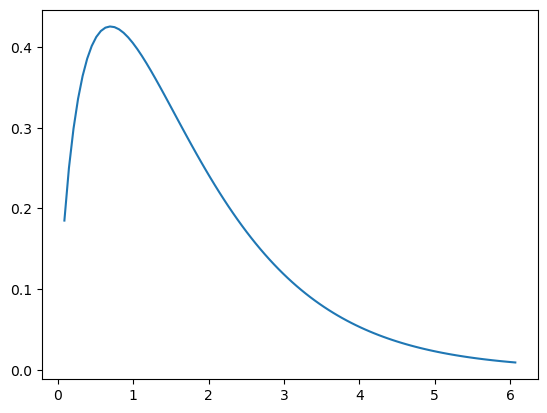

In [113]:
from scipy.stats import gamma

x = np.linspace(gamma.ppf(0.01, a),
                gamma.ppf(0.99, a), 100)

loc = 0
scale = 1
a = 1.7

dist = gamma(a, loc = loc, scale = scale)

y = dist.pdf(x)

plt.plot(x, y)

In [119]:
def super_quantile_ppf(dist, p = (.001, .999), n = 100):
    
    p_k = np.linspace(p[0], p[1], n)

    q_k = dist.ppf(p_k)
    # print(q_k)

    return np.nan_to_num(q_k.mean(), nan = np.inf)

super_quantile_ppf(dist)

1.725309906309762

In [120]:
%timeit super_quantile_ppf(dist)

182 µs ± 2.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [122]:
%timeit src.routing.super_quantile(y, p = (.001, .999))

112 µs ± 497 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [124]:
# q_k = np.linspace(.001, .999, 100)
%timeit y.mean() + q_k * y.std()

15.2 µs ± 56.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
